In [1]:
from lineage_motif.plot import *
from lineage_motif.resample import *
from lineage_motif.simulate import *

from Bio import Phylo
from Bio.Phylo.BaseTree import TreeMixin
import io

from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

pyplot.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({'font.size': 8})
mpl.rcParams['figure.dpi'] = 300
pd.set_option('display.max_rows', 100)
pyplot.rcParams["font.family"] = "Arial"

In [48]:
def _make_circle(color, size, x, y, alpha):
    da = DrawingArea(0, 0, 0, 0)
    p = mpatches.Circle((0, 0), size, color=color, alpha=alpha)
    da.add_artist(p)

    c1 = AnnotationBbox(da, 
                        (x,y),
                        xybox=(0, 0),
                        frameon=False,
                        xycoords=("data", "axes fraction"),
                        box_alignment=(0.5, 0.5),
                        boxcoords="offset points",
                        bboxprops={"edgecolor" : "none"},
                        pad=0)
    return c1

def _annot(number):
    if number < 0.0005:
        return '***'
    elif number < 0.005:
        return '**'
    elif number < 0.05:
        return '*'

subtree_type_list = ['doublet',
                     'triplet',
                     'quartet', 
                     'sextet',
                     'asym_quartet',
                     'asym_quintet',
                     'asym_sextet',
                     'asym_septet']

index_list = [[1,3], 
              [1,4,6], 
              [2,4,8,10], 
              [2,4,9,11,15,17],
              [1,4,7,9], 
              [1,4,7,10,12], 
              [1,4,7,10,13,15], 
              [1,4,7,10,13,16,18]
              ]

y_list = [[-0.06, -0.15], 
          [-0.06, -0.18, -0.27],
          [-0.06, -0.15, -0.27, -0.36],
          [-0.06, -0.15, -0.27, -0.36, -0.45, -0.54],
          [-0.06, -0.18, -0.30, -0.39],
          [-0.06, -0.18, -0.30, -0.42, -0.51],
          [-0.06, -0.18, -0.30, -0.42, -0.54, -0.63],
          [-0.06, -0.18, -0.30, -0.42, -0.54, -0.66, -0.75],
         ]

labelpad_list = [22.5, 40, 52.5, 80, 60, 80, 100, 120]

df_annotations = pd.DataFrame({'subtree_type': subtree_type_list,
                               'index': index_list,
                               'y': y_list,
                               'labelpad': labelpad_list})

def _make_annotation(cell_color_dict, ax, label, subtree_type):
    index_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['index'].values[0]
    y_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['y'].values[0]

    for index, y in zip(index_list_subtree, y_list_subtree):
        c_str = label[index]
        x = label
        ax.add_artist(_make_circle(cell_color_dict[c_str], 4.5, x, y, 0.4))
        ax.annotate(c_str, 
                    xy=(x, y), 
                    verticalalignment="center", 
                    horizontalalignment="center",
                    annotation_clip=False, 
                    xycoords=("data", "axes fraction"),
                    **{'fontname':'Arial', 'size':8})

def plot_deviation(subtree, 
                   df_true_melt_subset, 
                   df_null_zscores_i_c_melt_subset, 
                   df_null_zscores_i_c_melt_100resamples_subset, 
                   cell_color_dict,
                   fdr_type='fdr_tsbh',
                   cutoff='auto', 
                   title='auto',
                   multiple_datasets=False,
                   num_null=1000,
                   legend_bool=True,
                   legend_pos='outside',
                   save=False, 
                   image_format='png',
                   dpi=300,
                   image_save_path=None):
    
    """Plots deviation of `cutoff` number of subtrees in original dataset and `num_null` resamples.
    
    Args:
        subtree (string): Type of subtree.
        df_true_melt_subset (DataFrame): DataFrame with cutoff number of most significant subtrees for plotting.
            Sorted by z-score from most over-represented to most under-represented.
            Output from `dfs_for_plotting` function.
        df_null_zscores_i_c_melt_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of most significant
            subtrees across `num_null` random resamples.
            Output from `dfs_for_plotting` function.
        df_null_zscores_i_c_melt_100resamples_subset (DataFrame): Melted DataFrame with null z-score for `cutoff` number of 
            most significant subtrees across 100 random resamples.
            Output from `dfs_for_plotting` function.
        cell_color_dict (dict): Keys are cell fates, values are colors.
        fdr_type (string, optional): Use the Benjamini and Hochberg FDR correction if 'fdr_bh', use Benjamini and Hochberg FDR correction
            with two stage linear step-up procedure if 'fdr_tsbh'. Uses 'fdr_tsbh' by default.
        cutoff (string or NoneType or int, optional): Take `cutoff` number of subtrees with largest absolute z-scores 
            to include in plots.
            If not provided explicitly, will be automatically determined to take all subtrees with abs z-score > 1.
            If NoneType, take all subtrees.
        title (string, optional): Title to use for plot. If not provided explicitly, will be automatically determined to read `subtree` frequency.
        multiple_datasets (bool, optional): Modify x-axis label depending if single or multiple datasets were used.
        num_null (int, optional): Number of resamples used to calculate z-scores as part of null distribution.    
        legend_bool (bool, optional): Include legend in plot.
        legend_pos (string, optional): Position of legend (outside or inside).
        save (bool, optional): If True, save figure as file.
        image format (string, optional): Format of image file to be saved (png or svg).
        dpi (int, optional): Resolution of saved image file.
        image_save_path (string, optional): Path to saved image file.
    """

    df_true_melt_subset_sg = df_true_melt_subset.loc[df_true_melt_subset[f'adj_p_val_{fdr_type}']<0.05].copy()
    
    margins=0.05
    bbox_to_anchor=(0, 0)  
    figsize=(0.23*len(df_true_melt_subset)+margins, 2.5)

    sns.set_style('whitegrid')
    fig, ax = pyplot.subplots(figsize=figsize)
    pyplot.setp(ax.collections)

    sns.violinplot(x='label', 
                   y='observed', 
                   data=df_null_zscores_i_c_melt_subset, 
                   cut=0,
                   inner=None,
                   color='#BCBEC0',
                   scale='width',
                   linewidth=0,
                   )
    sns.stripplot(x='label', 
                  y='observed', 
                  data=df_null_zscores_i_c_melt_100resamples_subset, 
                  jitter=0.2,
                  color='gray',
                  size=0.5,
                 )
    pyplot.scatter(x="label", y="z-score", data=df_true_melt_subset, color='red', label='Observed count', s=2.5)
    pyplot.scatter(x="label", y="null z-score mean", data=df_true_melt_subset, color='gray', label=f'Null z-score across {num_null} resamples', s=2.5)
    pyplot.scatter(x="label", y="null z-score mean", data=df_true_melt_subset, color='black', label=f'Average null z-score', s=2.5)
    pyplot.scatter(x="label", y="null z-score min", data=df_true_melt_subset, color='gray', s=0, label='')
    pyplot.scatter(x="label", y="null z-score max", data=df_true_melt_subset, color='gray', s=0, label='')
    pyplot.scatter(x="label", y="z-score", data=df_true_melt_subset, color='red', label='', s=2.5)
    pyplot.errorbar(x="label", y="z-score", yerr="std", data=df_true_melt_subset, color='red', ls='None', alpha=0.5, label='')
    #pyplot.scatter(x="label", y="z-score", data=df_true_melt_subset_sg, color='red', s=25, alpha=0.35, label='Adjusted p-value < 0.05')

    # add annotations for adjusted p-value
    for label in df_true_melt_subset_sg['label'].values:
        adj_p_val = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label][f'adj_p_val_{fdr_type}'].values[0]
        val = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label]['z-score'].values[0]
        null = df_true_melt_subset_sg.loc[df_true_melt_subset_sg['label']==label]['null z-score mean'].values[0]
        if val > null:
            y_coord = val+max(df_true_melt_subset['z-score'])/10
            pyplot.annotate(_annot(adj_p_val), xy=(label, y_coord), ha='center', va='bottom', **{'fontname':'Arial', 'size':8})
        else:
            y_coord = val-max(df_true_melt_subset['z-score'])/10
            pyplot.annotate(_annot(adj_p_val), xy=(label, y_coord), ha='center', va='top', **{'fontname':'Arial', 'size':8})


    pyplot.margins(x=0.05, y=0.15)
    pyplot.grid(True)
    ax.set_xticklabels([])

    if title == 'auto':
        pyplot.title('Deviation from resamples', y=1.02, **{'fontname':'Arial', 'size':8})#, fontweight='bold')
    else:
        pyplot.title(f'{title}', y=1.02, **{'fontname':'Arial', 'size':8})#, fontweight='bold')
    pyplot.ylabel('z-score', **{'fontname':'Arial', 'size':8})
    pyplot.yticks(**{'fontname':'Arial', 'size':8})

    if legend_bool == True:
        legend_props = font_manager.FontProperties(family='Arial', style='normal', size=6)
        if legend_pos == 'outside':
            pyplot.legend(loc='upper left', framealpha=1, prop=legend_props, bbox_to_anchor=(1.05,1.0))
        elif legend_pos == 'inside':
            pyplot.legend(loc='upper right', framealpha=1, prop=legend_props)
    for i, artist in enumerate(ax.findobj(PathCollection)):
        artist.set_zorder(1)

    for subtree_label in df_true_melt_subset['label'].values:
        _make_annotation(cell_color_dict, ax, subtree_label, subtree)
            
    labelpad = df_annotations.loc[df_annotations['subtree_type']==subtree]['labelpad'].values[0]    
    
    if cutoff==None:
        pyplot.xlabel(f'All {subtree} combinations', labelpad=labelpad, **{'fontname':'Arial', 'size':8})
    else:
        if multiple_datasets == False:
            pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score)', labelpad=labelpad, **{'fontname':'Arial', 'size':8})
        else:
            pyplot.xlabel(f'{subtree.capitalize()} combinations \n(top {len(df_true_melt_subset)} by abs z-score across all datasets)', labelpad=labelpad, **{'fontname':'Arial', 'size':8})

    if save==True:
        pyplot.savefig(f"{image_save_path}.{image_format}", dpi=dpi, bbox_inches="tight")

In [3]:
cell_fates = ['A', 'B', 'C', 'D', 'E', 'F']
cell_color_dict = make_color_dict(cell_fates, ['#F89A3A', '#9C80B8', '#F071AB', '#F0E135','#5FC0D4', '#7EC352',])

In [4]:
num_trees = 1000
all_cells_list = []

for rep in range(10):
    all_trees_sorted = read_dataset(f"../data/comp_prog_model_v02/trees_trees{num_trees}_rep{rep}.txt")
    all_cells = make_df_all_cells(all_trees_sorted, make_cell_dict(cell_fates), 'observed', True)
    all_cells_list.append(all_cells)

all_cells_c = pd.concat(all_cells_list, axis=1)
all_cells_c

,observed,observed,observed,observed,observed,observed,observed,observed,observed,observed
A,1619,1666,1582,1589,1618,1648,1610,1585,1621,1613
B,1813,1770,1759,1771,1713,1741,1826,1694,1735,1761
C,1905,1920,1745,1860,1789,1850,1850,1639,1694,1814
D,1854,1693,1660,1707,1619,1776,1627,1666,1606,1751
E,1659,1425,1467,1440,1514,1616,1367,1531,1397,1412
F,1889,1538,1577,1636,1789,1708,1536,1670,1441,1591


In [5]:
all_cells_c_m = all_cells_c.sum(axis=1).to_frame('observed')
all_cells_c_m

,observed
A,16151
B,17583
C,18066
D,16959
E,14828
F,16375


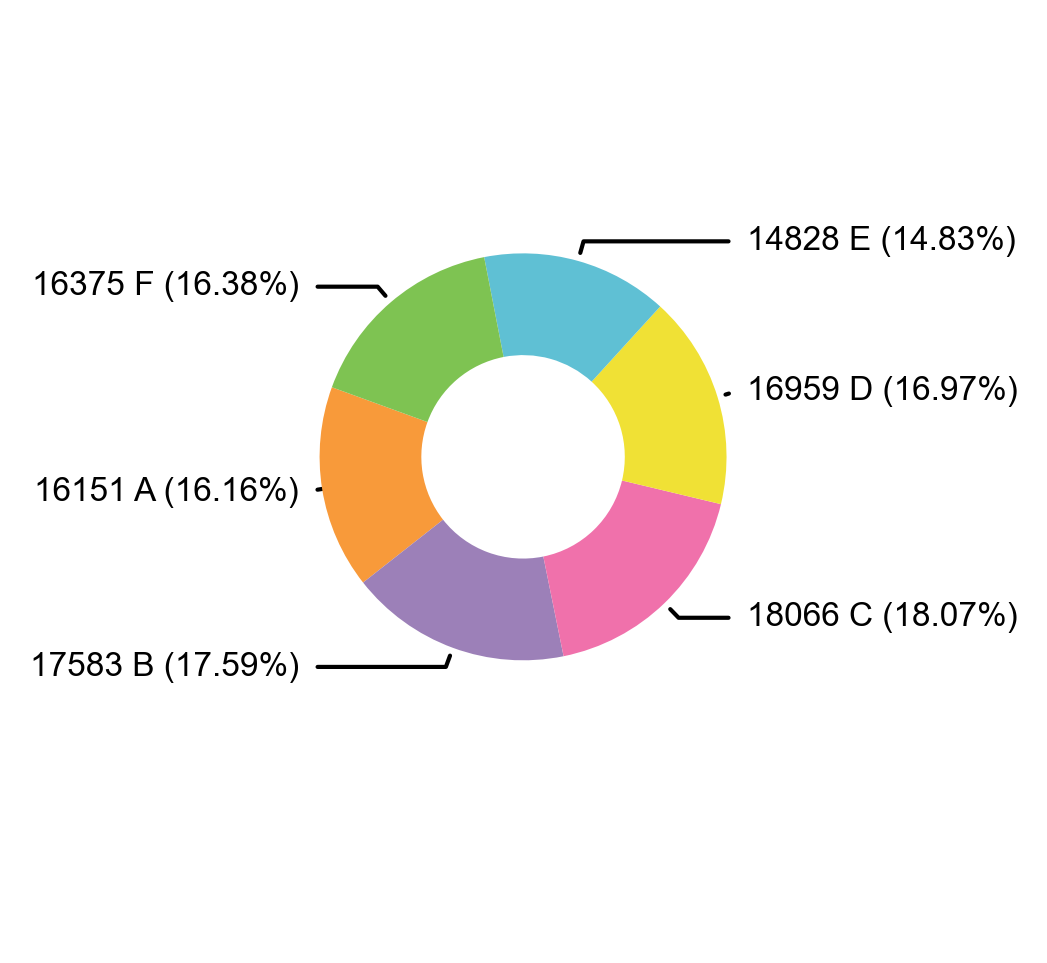

In [6]:
fig, ax = pyplot.subplots(1, 1, figsize=(3.25,3))
i=0

dict_all_cells_true = all_cells_c_m.sort_index()['observed'].to_dict()
cells = np.array([k for k, v in dict_all_cells_true.items()])
cell_counts = np.array([v for k, v in dict_all_cells_true.items()])
norm_cell_counts = np.round(cell_counts/cell_counts.sum()*100, 2)

norm_cell_counts_str = [f' ('+str(percent)+'%)' for ind, percent in enumerate(norm_cell_counts)]
annot = [str(count)+' '+cell+suffix for count, cell, suffix in zip(cell_counts, cells, norm_cell_counts_str)]

data = dict_all_cells_true.values()

colors_to_use = cell_color_dict.values()
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-200, colors=colors_to_use, )

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for b, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(annot[b], xy=(x, y), xytext=(1.1*np.sign(x), 1.1*y),
                horizontalalignment=horizontalalignment, **kw, **{'fontname':'Arial', 'size':8})

#ax.set_title(f"Pre-determined states \n cell fate proportions", y=1, **{'fontname':'DejaVu Sans', 'size':8})

pyplot.tight_layout(h_pad=-8, w_pad=4)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
pyplot.grid(False)
#pyplot.title("Cell fate proportions across zebrafish retina regions", y=0, **{'fontname':'DejaVu Sans', 'size':8}, fontweight="bold")

image_format = 'svg'

pyplot.savefig(f"comp_prog_model_cell_fate_proportions_v02_composite.{image_format}", dpi=300, bbox_inches="tight")

In [19]:
for i, j in enumerate(all_trees_sorted[990:]):
    print(i, j)

0 (((C,(C,(D,(E,(E,(F,F)))))),B),A)
1 (A,A)
2 (A,((((((D,(E,E)),(E,(F,F))),(((F,(F,F)),(F,(F,F))),D)),(C,(D,(D,D)))),B),A))
3 (A,(A,A))
4 (A,A)
5 ((B,(C,(C,(C,(D,(E,E)))))),(((C,(D,(D,(E,(F,(F,F)))))),(((D,((((E,(F,(F,F))),(F,F)),E),D)),(D,(D,(E,(E,(F,F)))))),(C,(C,C)))),(C,C)))
6 (((B,(B,B)),(C,(D,(D,D)))),A)
7 (A,(B,(B,B)))
8 (((((C,(D,((((F,F),(F,(F,(F,F)))),D),(D,D)))),B),(C,C)),(C,C)),(((C,(D,(D,(D,D)))),((C,(D,D)),(C,C))),(B,B)))
9 ((A,A),(((D,(((((F,F),(E,((((F,F),(F,(F,F))),E),E))),(F,(F,F))),E),E)),C),B))
10 


In [58]:
cell_color_dict_for_trees = make_color_dict(cell_fates, ['#df8a34', '#8c73a5', '#d86599', '#d8ca2f','#55acbe', '#71af49',])

In [63]:
tree = Phylo.read(io.StringIO(all_trees_sorted[998]), "newick")
tree.ladderize()
depth = max(TreeMixin.depths(tree, unit_branch_lengths=True).values())
size = depth*0.35
size

4.199999999999999

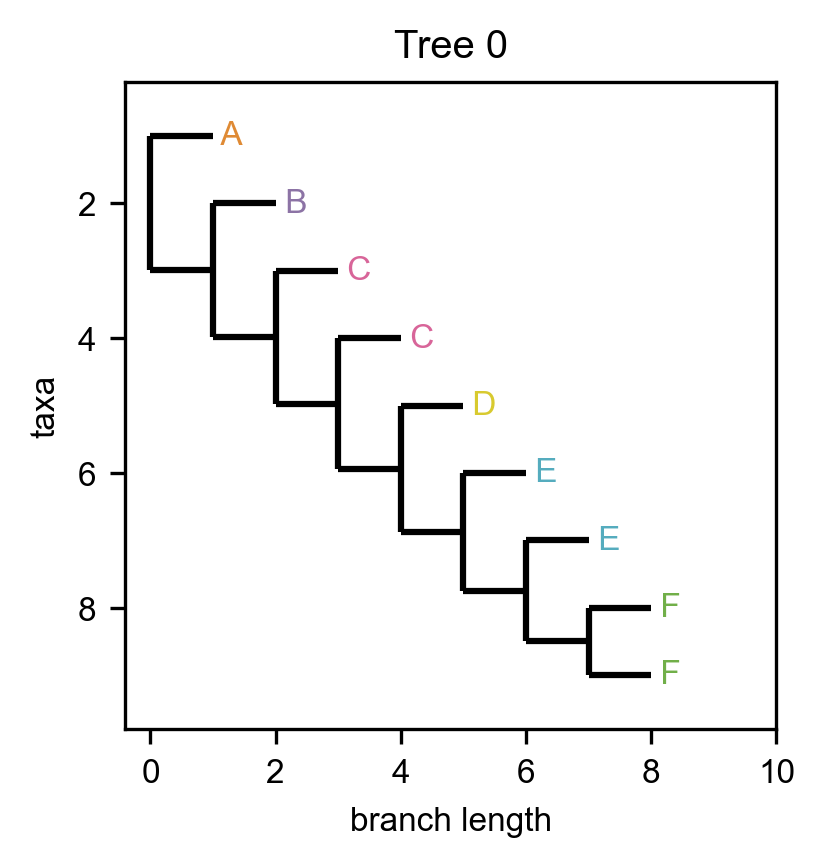

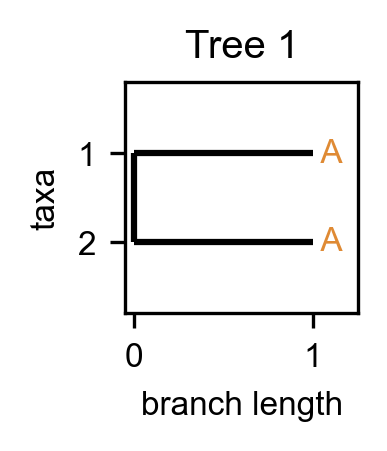

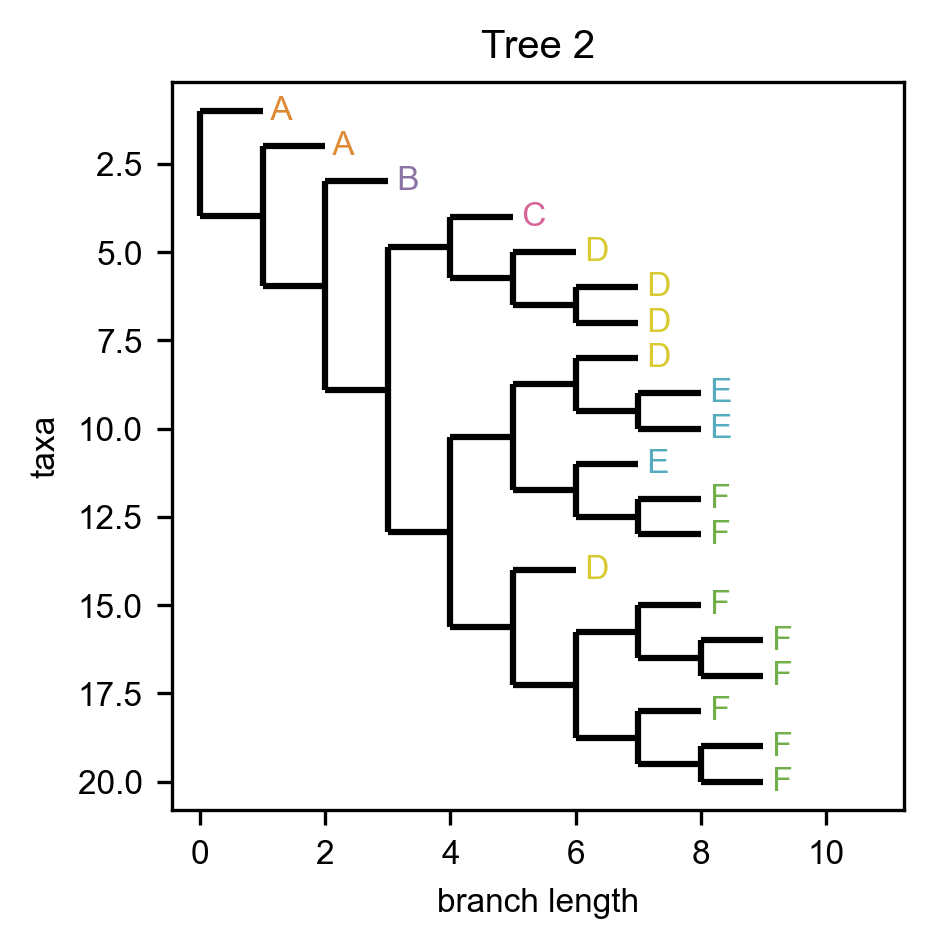

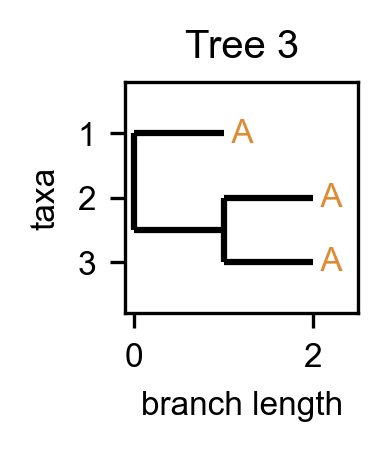

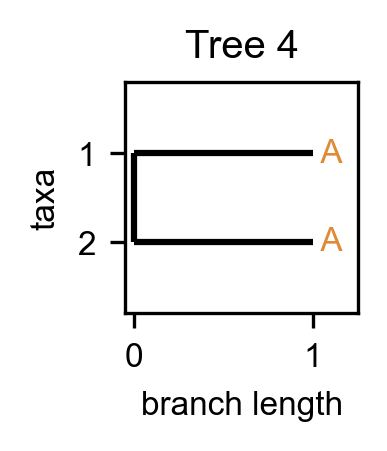

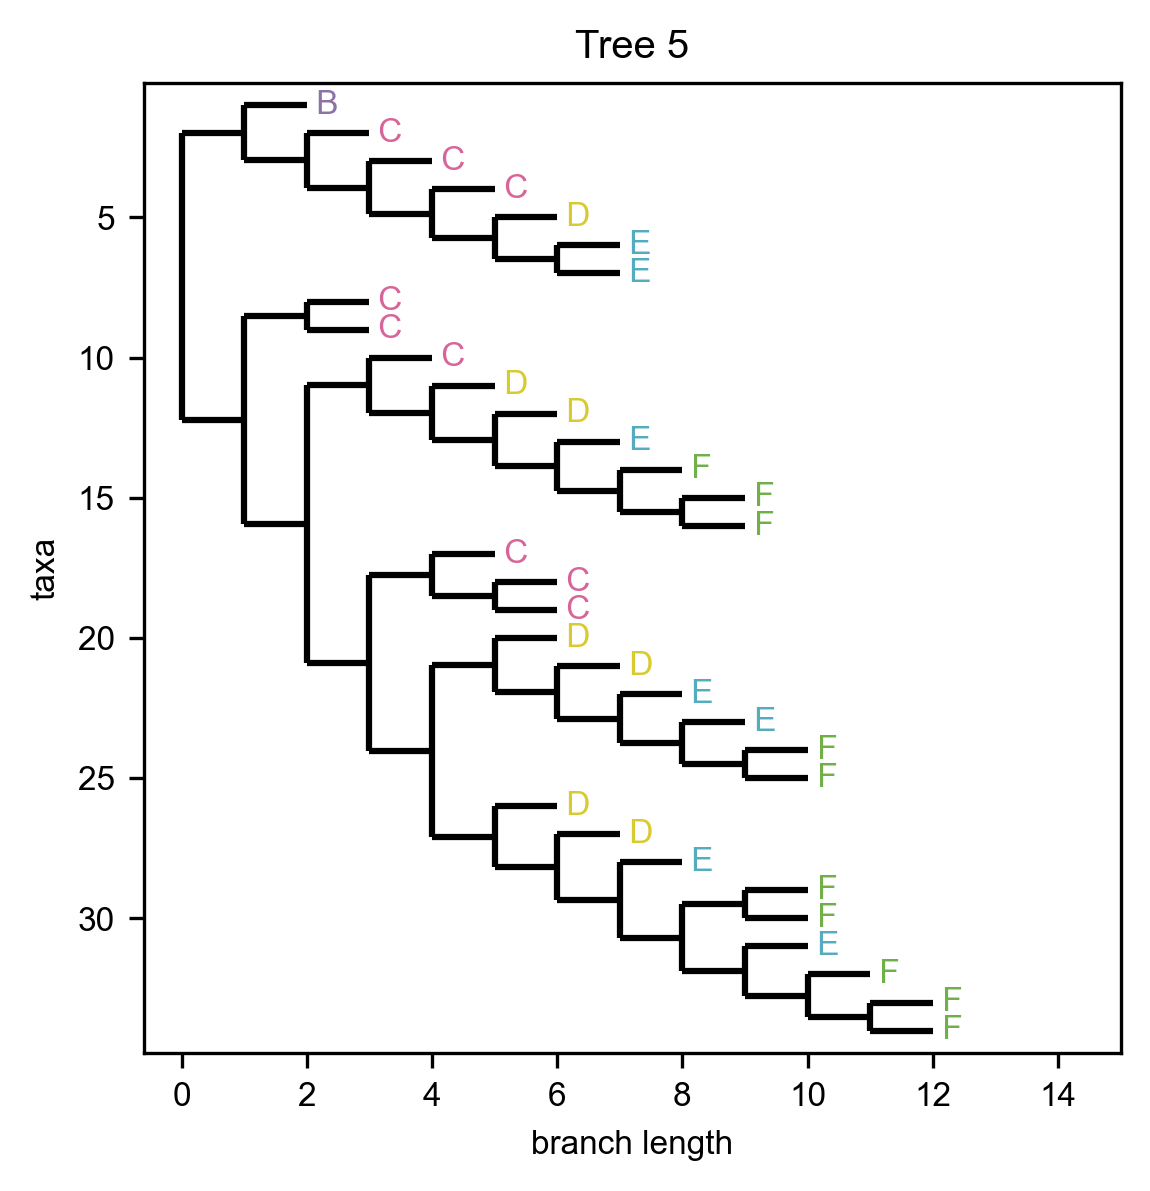

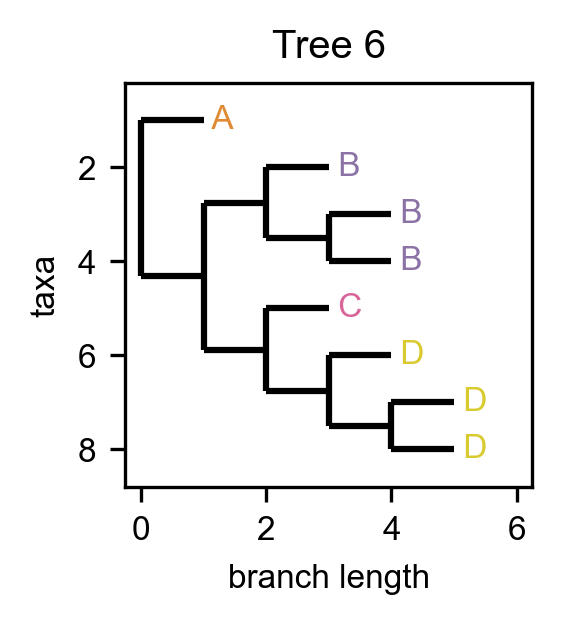

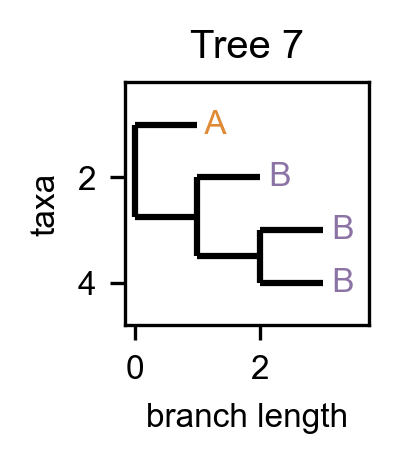

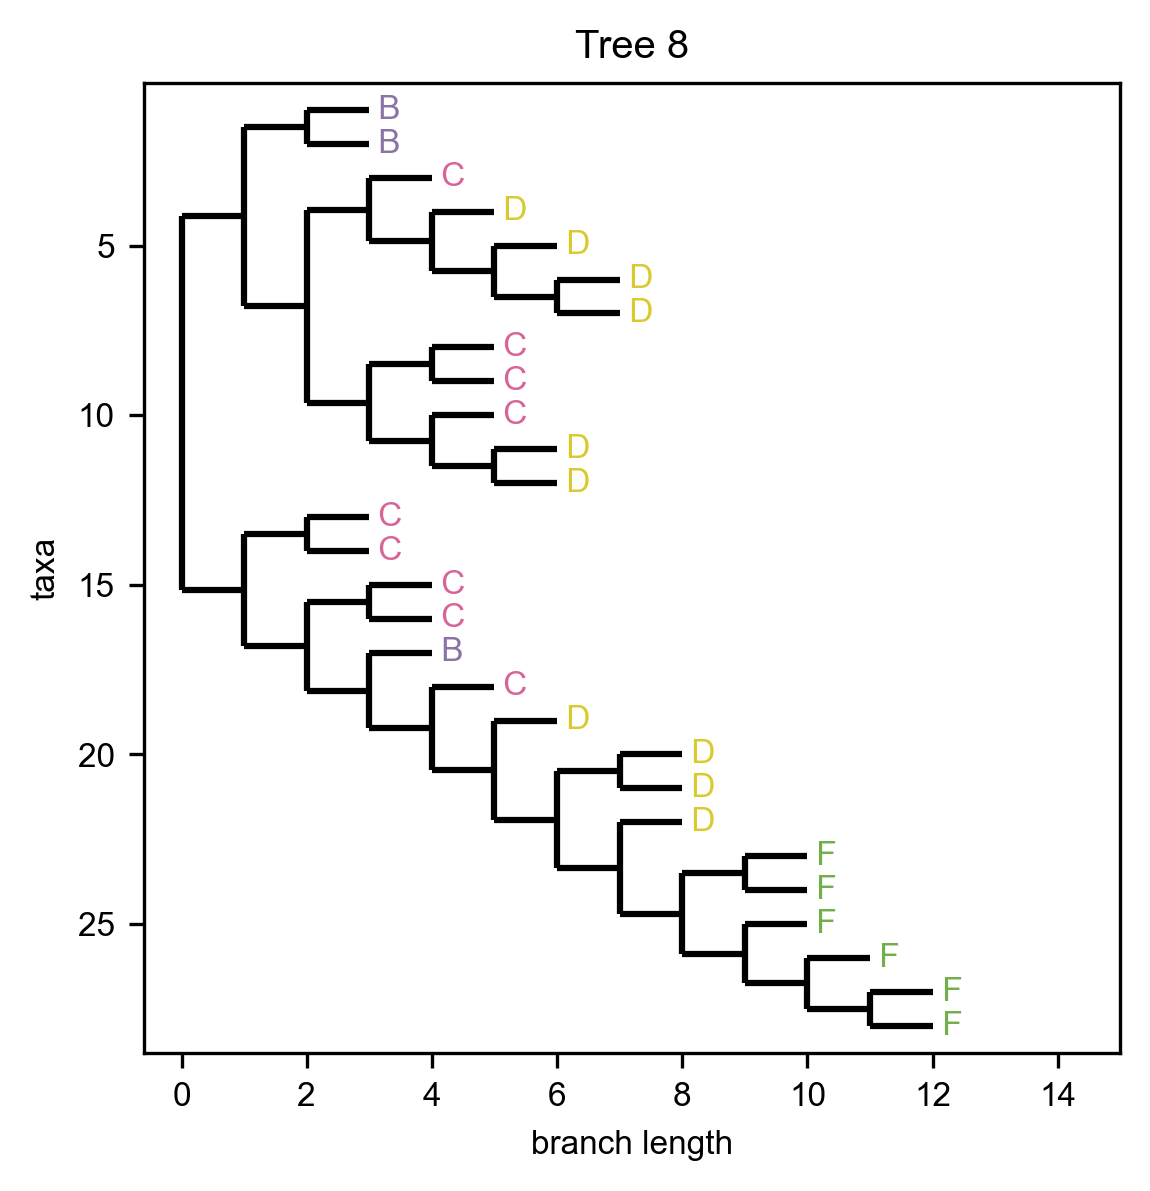

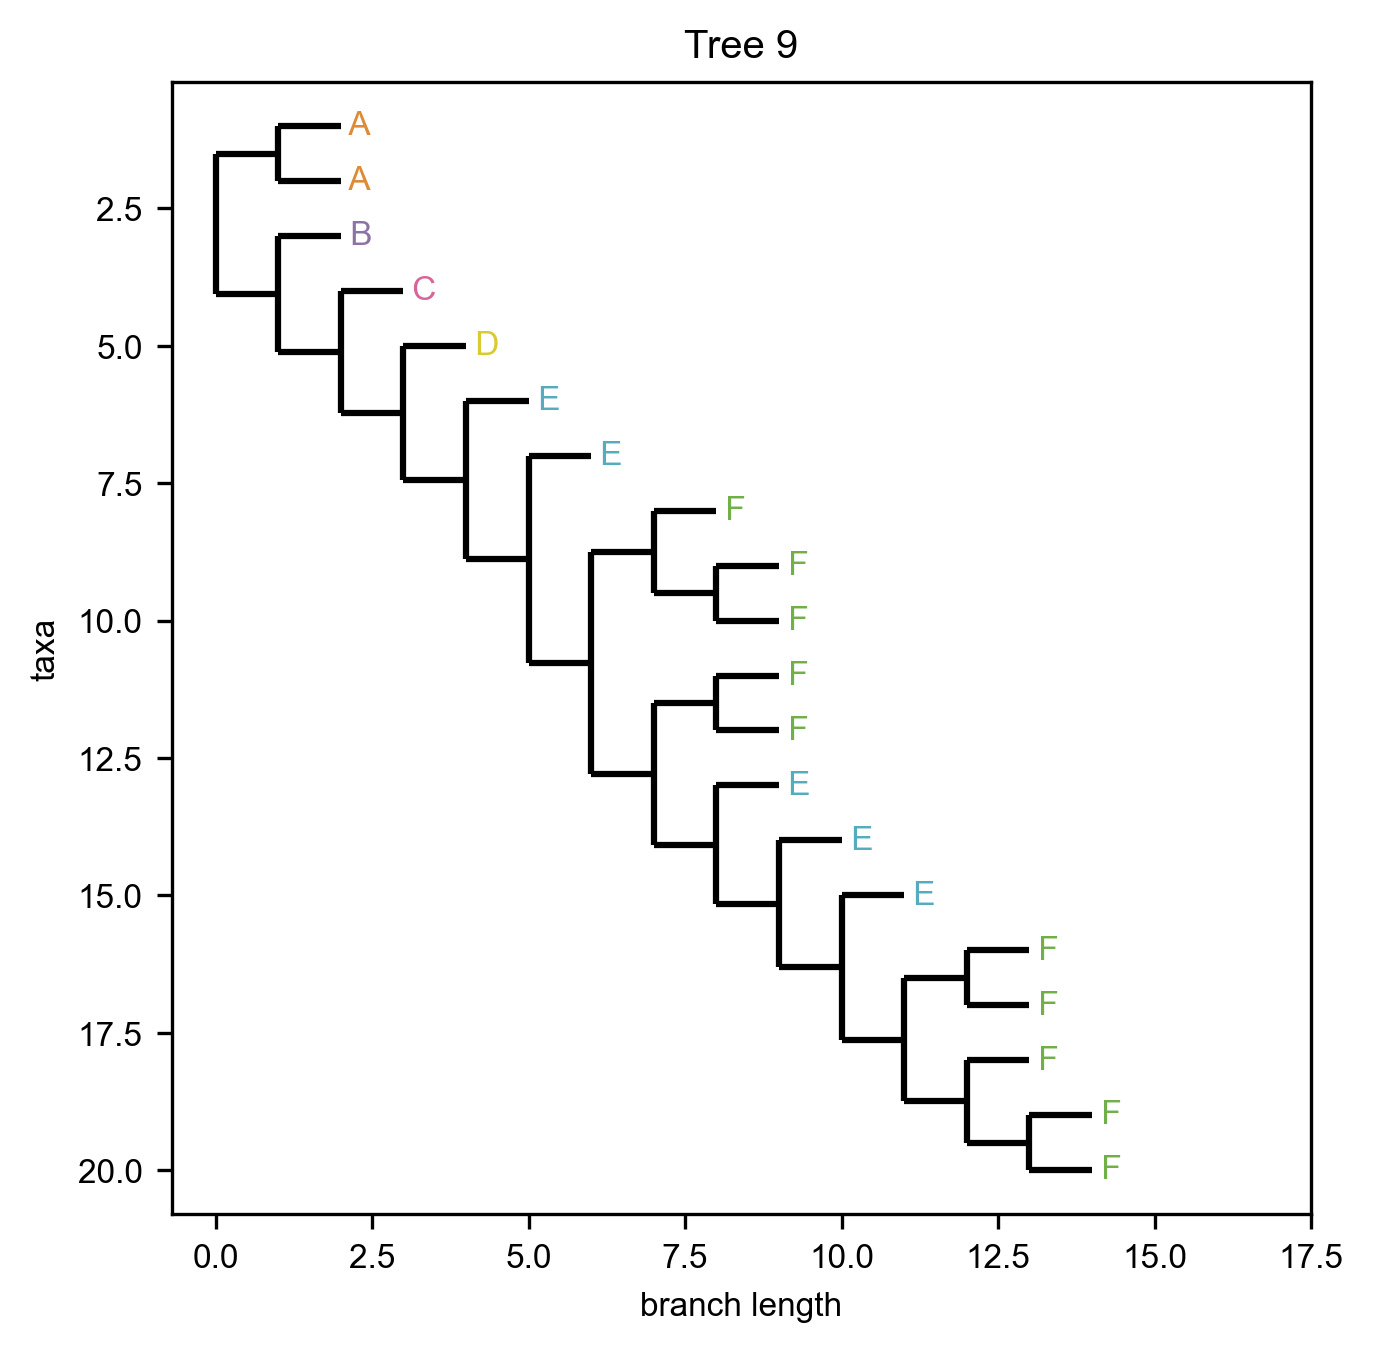

In [61]:
for i, ind in enumerate(range(990, 1000)):
    tree = Phylo.read(io.StringIO(all_trees_sorted[ind]), "newick")
    tree.ladderize()
    depth = max(TreeMixin.depths(tree, unit_branch_lengths=True).values())
    size = depth*0.35
    if size < 1:
        size = 1

    fig, ax = pyplot.subplots(1, 1, figsize=(size,size))

    Phylo.draw(tree,
            axes=ax,
            label_colors=cell_color_dict_for_trees,
            do_show=False
    )

    pyplot.title(f'Tree {i}')
    #pyplot.axis('off')
    pyplot.savefig(f"comp_prog_model_v02_tree_{i}.svg", bbox_inches="tight")

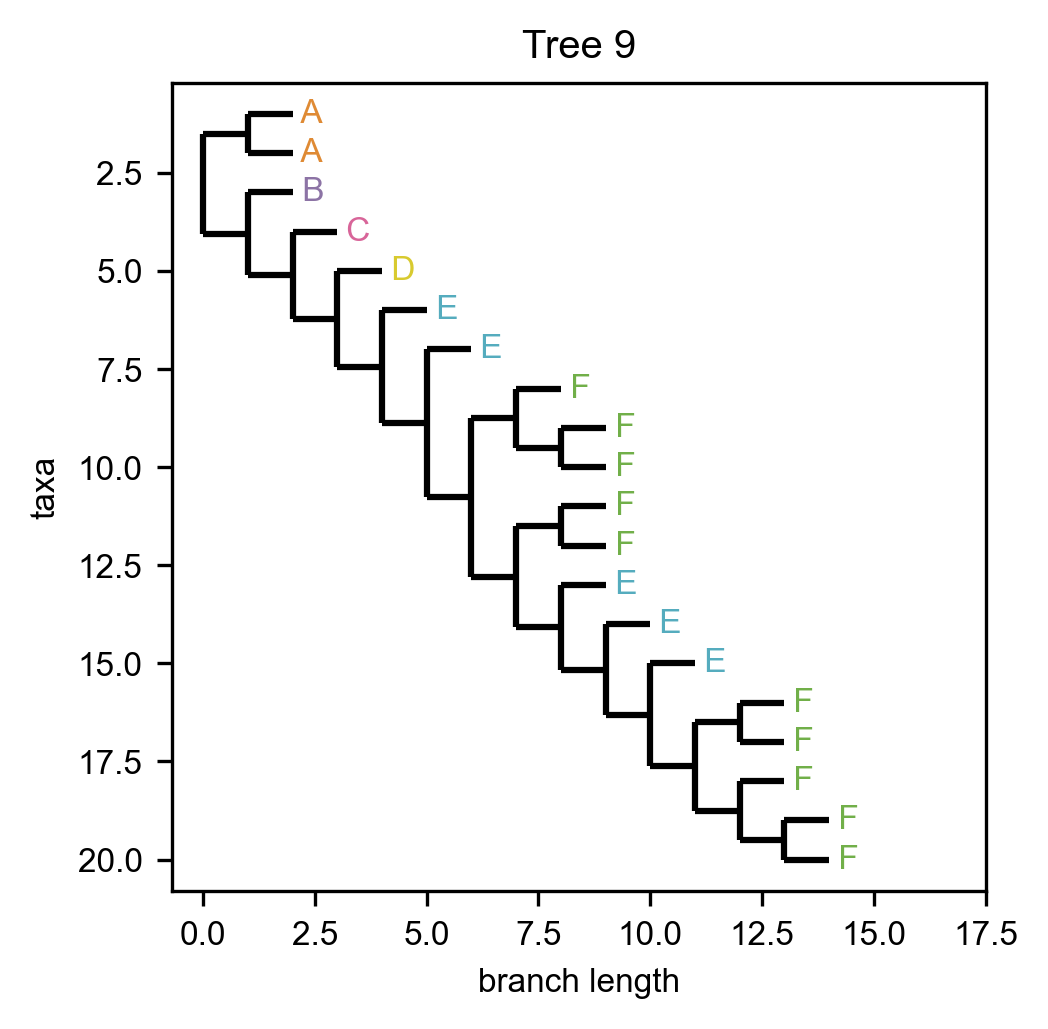

In [62]:
for i, ind in enumerate(range(990, 1000)):
    if i < 9:
        continue
    tree = Phylo.read(io.StringIO(all_trees_sorted[ind]), "newick")
    tree.ladderize()
    depth = max(TreeMixin.depths(tree, unit_branch_lengths=True).values())
    size = depth*0.25
    if size < 1:
        size = 1

    fig, ax = pyplot.subplots(1, 1, figsize=(size,size))

    Phylo.draw(tree,
            axes=ax,
            label_colors=cell_color_dict_for_trees,
            do_show=False
    )

    pyplot.title(f'Tree {i}')
    #pyplot.axis('off')
    pyplot.savefig(f"comp_prog_model_v02_tree_{i}.svg", bbox_inches="tight")

In [29]:
subtree_list = ['doublet',
                'triplet',
                ]

num_trees_list = [500]

df_true_melt_subset_list = []
df_null_zscores_i_c_melt_subset_list = []

for subtree in subtree_list:
    for num_trees in num_trees_list:
        for rep in range(10):
            df_true_melt_subset = pd.read_csv(f'../data/comp_prog_model_v02/df_true_melt_subset_{subtree}_trees{num_trees}_rep{rep}.csv', index_col=0)
            df_true_melt_subset['rep'] = rep
            df_true_melt_subset['subtree'] = subtree
            df_true_melt_subset_list.append(df_true_melt_subset)

            df_null_zscores_i_c_melt_subset = pd.read_csv(f'../data/comp_prog_model_v02/df_null_zscores_i_c_melt_subset_{subtree}_trees{num_trees}_rep{rep}.csv', index_col=0)
            df_null_zscores_i_c_melt_subset['rep'] = rep
            df_null_zscores_i_c_melt_subset['subtree'] = subtree
            df_null_zscores_i_c_melt_subset_list.append(df_null_zscores_i_c_melt_subset)

In [30]:
df_true_melt_subset_c = pd.concat(df_true_melt_subset_list)
df_true_melt_subset_c

,subtree_val,observed,z-score,abs z-score,label,null min,null mean,null max,p_val,adj_p_val_fdr_bh,adj_p_val_fdr_tsbh,null z-score min,null z-score mean,null z-score max,rep,subtree
20,20,346.0,46.250512,46.250512,"(F,F)",25.0,42.923,66.0,0.000999,0.000999,0.000999,-2.131623,-0.023312,2.001598,0,doublet
18,18,218.0,33.942907,33.942907,"(E,E)",13.0,32.819,52.0,0.000999,0.000999,0.000999,-3.660622,-0.158116,2.796264,0,doublet
15,15,228.0,29.774197,29.774197,"(D,D)",19.0,39.167,62.0,0.000999,0.000999,0.000999,-2.241631,0.068639,2.825816,0,doublet
0,0,208.0,28.802165,28.802165,"(A,A)",17.0,38.089,55.0,0.000999,0.000999,0.000999,-2.226477,0.088527,2.367047,0,doublet
11,11,251.0,28.020395,28.020395,"(C,C)",29.0,49.859,76.0,0.000999,0.000999,0.000999,-1.796016,-0.114238,2.960935,0,doublet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,10,0.0,-4.879876,4.879876,"(A,(C,C))",11.0,22.738,38.0,0.000000,0.000000,0.000000,-2.528434,-0.029752,1.776820,9,triplet
59,59,0.0,-5.924363,5.924363,"(C,(F,F))",16.0,33.025,49.0,0.000000,0.000000,0.000000,-2.163291,0.024384,2.335093,9,triplet
79,79,0.0,-5.929614,5.929614,"(D,(F,F))",17.0,33.671,53.0,0.000000,0.000000,0.000000,-1.706438,-0.035395,2.354974,9,triplet
19,19,0.0,-5.950489,5.950489,"(A,(F,F))",19.0,34.656,56.0,0.000000,0.000000,0.000000,-2.699285,-0.008011,2.645112,9,triplet


In [49]:
cutoff=12
subtree = 'doublet'

df_true_melt_subset_c_subtree = df_true_melt_subset_c.loc[df_true_melt_subset_c['subtree']==subtree]
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree_m.sort_values('abs z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m.loc[df_true_melt_subset_c_subtree_m['subtree_val'].isin(subtree_vals_to_use)]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m_ss.sort_values('z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_56411/2675269742.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()


,label,subtree_val,observed,z-score,abs z-score,null min,null mean,null max,p_val,adj_p_val_fdr_bh,adj_p_val_fdr_tsbh,null z-score min,null z-score mean,null z-score max,rep
20,"(F,F)",20.0,339.2,47.948962,47.948962,21.8,40.5026,61.6,0.000999,0.000999,0.000999,-2.239312,-0.008345,2.646663,4.5
18,"(E,E)",18.0,217.5,32.518470,32.518470,15.8,33.2430,51.4,0.000999,0.000999,0.000999,-2.453127,0.027020,2.497728,4.5
15,"(D,D)",15.0,231.4,29.657684,29.657684,22.4,41.5432,63.7,0.000999,0.000999,0.000999,-2.263219,0.035624,2.929081,4.5
11,"(C,C)",11.0,241.2,28.965446,28.965446,25.6,46.2845,68.8,0.000999,0.000999,0.000999,-2.474703,-0.033551,2.674502,4.5
6,"(B,B)",6.0,221.1,27.221857,27.221857,24.2,44.0722,66.5,0.000999,0.000999,0.000999,-2.326719,0.003568,2.586076,4.5
0,"(A,A)",0.0,194.6,26.416394,26.416394,18.1,36.6054,57.4,0.000999,0.000999,0.000999,-2.303236,0.021673,2.583365,4.5
10,"(B,F)",10.0,0.0,-9.349590,9.349590,57.3,83.8605,116.6,0.000999,0.000999,0.000999,-2.530885,-0.013343,2.884058,4.5
2,"(A,C)",2.0,0.0,-9.352431,9.352431,55.2,82.0093,111.4,0.000999,0.000999,0.000999,-2.608939,-0.017231,2.802221,4.5
8,"(B,D)",8.0,0.0,-9.520044,9.520044,58.3,85.4835,116.3,0.000999,0.000999,0.000999,-2.401966,-0.047559,2.539250,4.5
14,"(C,F)",14.0,0.0,-9.610877,9.610877,58.8,86.1682,118.8,0.000999,0.000999,0.000999,-2.417991,-0.002347,2.624056,4.5


In [50]:
df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()
std_list = [df_true_melt_subset_c_subtree_std.loc[df_true_melt_subset_c_subtree_std['label']==i]['z-score'].values[0] for i in df_true_melt_subset_c_subtree_m_ss['label']]
df_true_melt_subset_c_subtree_m_ss['std'] = std_list
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_56411/3231623101.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()


,label,subtree_val,observed,z-score,abs z-score,null min,null mean,null max,p_val,adj_p_val_fdr_bh,adj_p_val_fdr_tsbh,null z-score min,null z-score mean,null z-score max,rep,std
20,"(F,F)",20.0,339.2,47.948962,47.948962,21.8,40.5026,61.6,0.000999,0.000999,0.000999,-2.239312,-0.008345,2.646663,4.5,1.819658
18,"(E,E)",18.0,217.5,32.518470,32.518470,15.8,33.2430,51.4,0.000999,0.000999,0.000999,-2.453127,0.027020,2.497728,4.5,1.701155
15,"(D,D)",15.0,231.4,29.657684,29.657684,22.4,41.5432,63.7,0.000999,0.000999,0.000999,-2.263219,0.035624,2.929081,4.5,0.890392
11,"(C,C)",11.0,241.2,28.965446,28.965446,25.6,46.2845,68.8,0.000999,0.000999,0.000999,-2.474703,-0.033551,2.674502,4.5,1.464945
6,"(B,B)",6.0,221.1,27.221857,27.221857,24.2,44.0722,66.5,0.000999,0.000999,0.000999,-2.326719,0.003568,2.586076,4.5,1.436505
0,"(A,A)",0.0,194.6,26.416394,26.416394,18.1,36.6054,57.4,0.000999,0.000999,0.000999,-2.303236,0.021673,2.583365,4.5,1.634256
10,"(B,F)",10.0,0.0,-9.349590,9.349590,57.3,83.8605,116.6,0.000999,0.000999,0.000999,-2.530885,-0.013343,2.884058,4.5,0.336727
2,"(A,C)",2.0,0.0,-9.352431,9.352431,55.2,82.0093,111.4,0.000999,0.000999,0.000999,-2.608939,-0.017231,2.802221,4.5,0.254631
8,"(B,D)",8.0,0.0,-9.520044,9.520044,58.3,85.4835,116.3,0.000999,0.000999,0.000999,-2.401966,-0.047559,2.539250,4.5,0.227165
14,"(C,F)",14.0,0.0,-9.610877,9.610877,58.8,86.1682,118.8,0.000999,0.000999,0.000999,-2.417991,-0.002347,2.624056,4.5,0.439970


In [51]:
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
subtree_vals_to_use

array([20., 18., 15., 11.,  6.,  0., 10.,  2.,  8., 14., 12.,  7.])

In [52]:
df_null_zscores_i_c_melt_subset_c = pd.concat(df_null_zscores_i_c_melt_subset_list)
df_null_zscores_i_c_melt_subset_c_subtree = df_null_zscores_i_c_melt_subset_c.loc[df_null_zscores_i_c_melt_subset_c['subtree']==subtree]

df_null_zscores_i_c_melt_subset_c_subtree_ss = pd.concat([df_null_zscores_i_c_melt_subset_c_subtree.loc[df_null_zscores_i_c_melt_subset_c_subtree['subtree_val']==subtree_val_to_use] for subtree_val_to_use in subtree_vals_to_use])
df_null_zscores_i_c_melt_subset_c_subtree_ss

,subtree_val,observed,label,rep,subtree
2000,20,1.694518,"(F,F)",0,doublet
2001,20,-0.599351,"(F,F)",0,doublet
2002,20,0.622923,"(F,F)",0,doublet
2003,20,2.001598,"(F,F)",0,doublet
2004,20,0.164537,"(F,F)",0,doublet
...,...,...,...,...,...
795,7,0.595998,"(B,C)",9,doublet
796,7,1.140618,"(B,C)",9,doublet
797,7,-0.383308,"(B,C)",9,doublet
798,7,0.160707,"(B,C)",9,doublet


In [53]:
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0 = df_null_zscores_i_c_melt_subset_c_subtree_ss.loc[df_null_zscores_i_c_melt_subset_c_subtree_ss['rep']==0]
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0

,subtree_val,observed,label,rep,subtree
2000,20,1.694518,"(F,F)",0,doublet
2001,20,-0.599351,"(F,F)",0,doublet
2002,20,0.622923,"(F,F)",0,doublet
2003,20,2.001598,"(F,F)",0,doublet
2004,20,0.164537,"(F,F)",0,doublet
...,...,...,...,...,...
795,7,1.012621,"(B,C)",0,doublet
796,7,0.047704,"(B,C)",0,doublet
797,7,0.047704,"(B,C)",0,doublet
798,7,-1.024386,"(B,C)",0,doublet


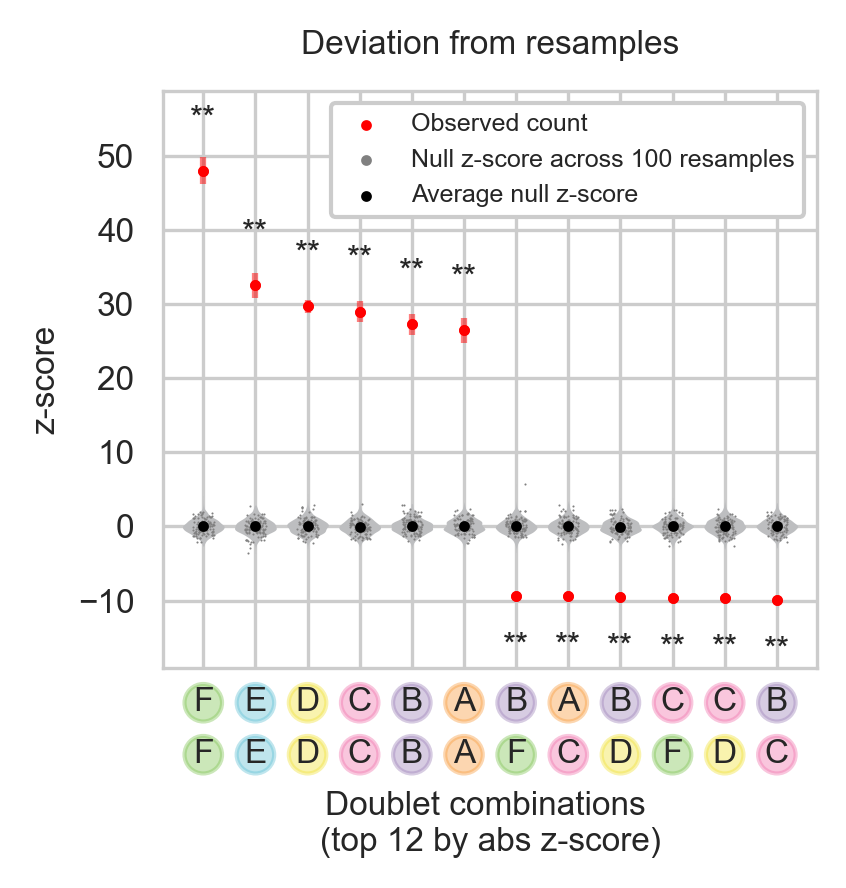

In [54]:
plot_deviation('doublet', 
               df_true_melt_subset_c_subtree_m_ss, 
               df_null_zscores_i_c_melt_subset_c_subtree_ss,
               df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0,
               cell_color_dict,
               legend_bool=True,
               legend_pos='inside',
               num_null=100,
               save=True, 
                   image_format='svg',
                   dpi=300,
                   image_save_path='comp_prog_model_v02_doublets')

In [55]:
cutoff=12
subtree = 'triplet'

df_true_melt_subset_c_subtree = df_true_melt_subset_c.loc[df_true_melt_subset_c['subtree']==subtree]
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()
df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree_m.sort_values('abs z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m.loc[df_true_melt_subset_c_subtree_m['subtree_val'].isin(subtree_vals_to_use)]
df_true_melt_subset_c_subtree_m_ss = df_true_melt_subset_c_subtree_m_ss.sort_values('z-score', ascending=False)
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_56411/512290912.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_m = df_true_melt_subset_c_subtree.groupby('label').mean().reset_index()


,label,subtree_val,observed,z-score,abs z-score,null min,null mean,null max,p_val,adj_p_val_fdr_bh,adj_p_val_fdr_tsbh,null z-score min,null z-score mean,null z-score max,rep
35,"(E,(F,F))",99.0,117.4,17.690756,17.690756,11.9,26.8124,45.0,0.0,0.0,0.0,-2.441835,-0.014163,2.563544,4.5
23,"(D,(E,E))",77.0,75.1,12.221409,12.221409,7.9,20.4299,35.6,0.0,0.0,0.0,-2.516438,0.011176,2.831784,4.5
12,"(C,(D,D))",54.0,71.5,10.232250,10.232250,9.3,23.1405,40.6,0.0,0.0,0.0,-2.266886,-0.025770,2.637755,4.5
6,"(B,(C,C))",30.0,73.5,9.898708,9.898708,10.5,25.1649,43.4,0.0,0.0,0.0,-2.320786,0.007724,2.916679,4.5
0,"(A,(B,B))",5.0,62.7,8.911819,8.911819,8.3,21.8045,36.8,0.0,0.0,0.0,-2.629272,0.013822,2.777323,4.5
2,"(A,(D,D))",14.0,0.0,-4.865535,4.865535,9.4,22.6770,39.5,0.0,0.0,0.0,-2.171174,0.009344,2.686277,4.5
1,"(A,(C,C))",10.0,0.0,-4.890642,4.890642,10.2,23.5814,40.1,0.0,0.0,0.0,-2.333316,-0.048468,2.317336,4.5
7,"(B,(D,D))",34.0,0.0,-4.965098,4.965098,10.2,24.2089,41.3,0.0,0.0,0.0,-2.269537,0.044429,2.681733,4.5
25,"(D,(F,F))",79.0,0.0,-5.772053,5.772053,16.0,31.7361,50.7,0.0,0.0,0.0,-2.249550,-0.017670,2.427989,4.5
4,"(A,(F,F))",19.0,0.0,-5.907793,5.907793,17.4,33.2337,52.0,0.0,0.0,0.0,-2.412380,0.017024,2.761859,4.5


In [56]:
df_true_melt_subset_c_subtree.loc[df_true_melt_subset_c_subtree['label']=='(F,(F,F))']

,subtree_val,observed,z-score,abs z-score,label,null min,null mean,null max,p_val,adj_p_val_fdr_bh,adj_p_val_fdr_tsbh,null z-score min,null z-score mean,null z-score max,rep,subtree


In [57]:
df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()
std_list = [df_true_melt_subset_c_subtree_std.loc[df_true_melt_subset_c_subtree_std['label']==i]['z-score'].values[0] for i in df_true_melt_subset_c_subtree_m_ss['label']]
df_true_melt_subset_c_subtree_m_ss['std'] = std_list
df_true_melt_subset_c_subtree_m_ss

/var/folders/qh/fh2bxgqd41l4771p5sx67x8w0000gn/T/ipykernel_56411/3231623101.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_true_melt_subset_c_subtree_std = df_true_melt_subset_c_subtree.groupby('label').std().reset_index()


,label,subtree_val,observed,z-score,abs z-score,null min,null mean,null max,p_val,adj_p_val_fdr_bh,adj_p_val_fdr_tsbh,null z-score min,null z-score mean,null z-score max,rep,std
35,"(E,(F,F))",99.0,117.4,17.690756,17.690756,11.9,26.8124,45.0,0.0,0.0,0.0,-2.441835,-0.014163,2.563544,4.5,2.483028
23,"(D,(E,E))",77.0,75.1,12.221409,12.221409,7.9,20.4299,35.6,0.0,0.0,0.0,-2.516438,0.011176,2.831784,4.5,1.274395
12,"(C,(D,D))",54.0,71.5,10.232250,10.232250,9.3,23.1405,40.6,0.0,0.0,0.0,-2.266886,-0.025770,2.637755,4.5,1.535737
6,"(B,(C,C))",30.0,73.5,9.898708,9.898708,10.5,25.1649,43.4,0.0,0.0,0.0,-2.320786,0.007724,2.916679,4.5,0.974967
0,"(A,(B,B))",5.0,62.7,8.911819,8.911819,8.3,21.8045,36.8,0.0,0.0,0.0,-2.629272,0.013822,2.777323,4.5,1.254961
2,"(A,(D,D))",14.0,0.0,-4.865535,4.865535,9.4,22.6770,39.5,0.0,0.0,0.0,-2.171174,0.009344,2.686277,4.5,0.204093
1,"(A,(C,C))",10.0,0.0,-4.890642,4.890642,10.2,23.5814,40.1,0.0,0.0,0.0,-2.333316,-0.048468,2.317336,4.5,0.252392
7,"(B,(D,D))",34.0,0.0,-4.965098,4.965098,10.2,24.2089,41.3,0.0,0.0,0.0,-2.269537,0.044429,2.681733,4.5,0.219725
25,"(D,(F,F))",79.0,0.0,-5.772053,5.772053,16.0,31.7361,50.7,0.0,0.0,0.0,-2.249550,-0.017670,2.427989,4.5,0.322267
4,"(A,(F,F))",19.0,0.0,-5.907793,5.907793,17.4,33.2337,52.0,0.0,0.0,0.0,-2.412380,0.017024,2.761859,4.5,0.171383


In [58]:
subtree_vals_to_use = df_true_melt_subset_c_subtree_m_ss['subtree_val'].values[:cutoff]
subtree_vals_to_use

array([99., 77., 54., 30.,  5., 14., 10., 34., 79., 19., 59., 39.])

In [59]:
df_null_zscores_i_c_melt_subset_c = pd.concat(df_null_zscores_i_c_melt_subset_list)
df_null_zscores_i_c_melt_subset_c_subtree = df_null_zscores_i_c_melt_subset_c.loc[df_null_zscores_i_c_melt_subset_c['subtree']==subtree]

df_null_zscores_i_c_melt_subset_c_subtree_ss = pd.concat([df_null_zscores_i_c_melt_subset_c_subtree.loc[df_null_zscores_i_c_melt_subset_c_subtree['subtree_val']==subtree_val_to_use] for subtree_val_to_use in subtree_vals_to_use])
df_null_zscores_i_c_melt_subset_c_subtree_ss

,subtree_val,observed,label,rep,subtree
9900,99,-1.626551,"(E,(F,F))",0,triplet
9901,99,0.225088,"(E,(F,F))",0,triplet
9902,99,0.595085,"(E,(F,F))",0,triplet
9903,99,1.150586,"(E,(F,F))",0,triplet
9904,99,0.780166,"(E,(F,F))",0,triplet
...,...,...,...,...,...
3995,39,1.984222,"(B,(F,F))",9,triplet
3996,39,0.620916,"(B,(F,F))",9,triplet
3997,39,-0.909052,"(B,(F,F))",9,triplet
3998,39,-0.738937,"(B,(F,F))",9,triplet


In [60]:
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0 = df_null_zscores_i_c_melt_subset_c_subtree_ss.loc[df_null_zscores_i_c_melt_subset_c_subtree_ss['rep']==0]
df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0

,subtree_val,observed,label,rep,subtree
9900,99,-1.626551,"(E,(F,F))",0,triplet
9901,99,0.225088,"(E,(F,F))",0,triplet
9902,99,0.595085,"(E,(F,F))",0,triplet
9903,99,1.150586,"(E,(F,F))",0,triplet
9904,99,0.780166,"(E,(F,F))",0,triplet
...,...,...,...,...,...
3995,39,0.593428,"(B,(F,F))",0,triplet
3996,39,0.064043,"(B,(F,F))",0,triplet
3997,39,0.416933,"(B,(F,F))",0,triplet
3998,39,-0.995010,"(B,(F,F))",0,triplet


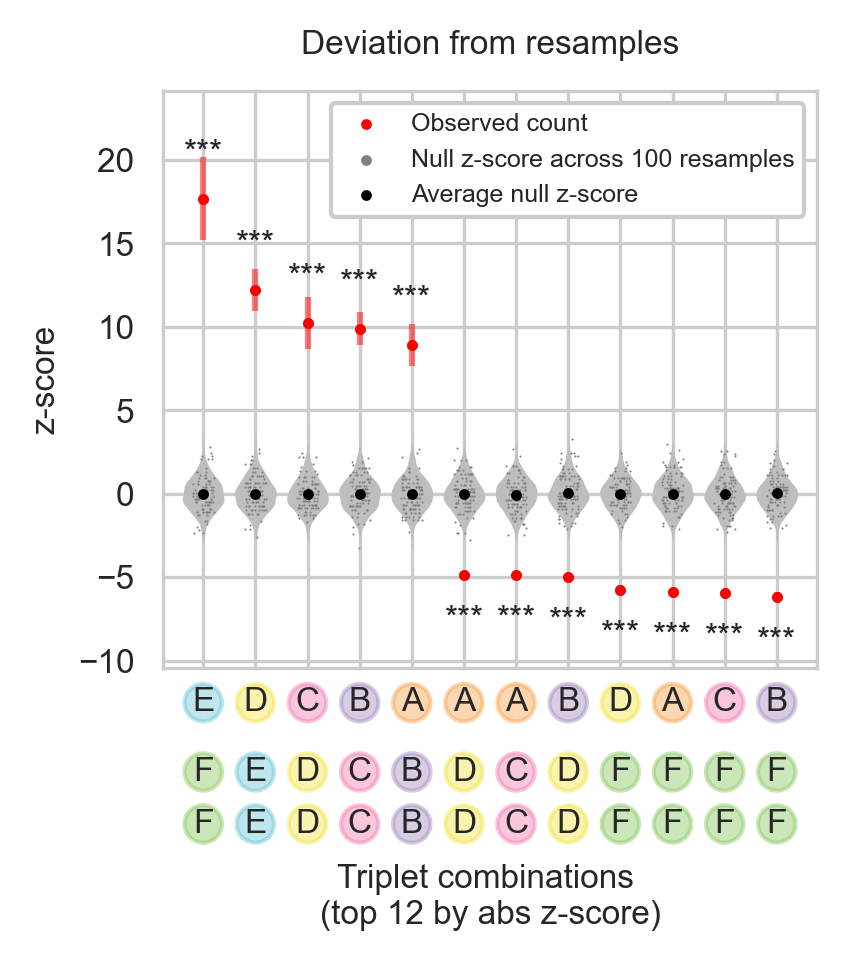

In [62]:
plot_deviation('triplet', 
               df_true_melt_subset_c_subtree_m_ss, 
               df_null_zscores_i_c_melt_subset_c_subtree_ss,
               df_null_zscores_i_c_melt_subset_c_subtree_ss_rep0,
               cell_color_dict,
               legend_bool=True,
               num_null=100,
               legend_pos='inside',
               save=True, 
                   image_format='svg',
                   dpi=300,
                   image_save_path='comp_prog_model_v02_triplets')

In [145]:
def _make_circle(color, size, x, y, alpha):
    da = DrawingArea(0, 0, 0, 0)
    p = mpatches.Circle((0, 0), size, color=color, alpha=alpha)
    da.add_artist(p)

    c1 = AnnotationBbox(da, 
                        (x,y),
                        xybox=(0, 0),
                        frameon=False,
                        xycoords=("data", "axes fraction"),
                        box_alignment=(0.5, 0.5),
                        boxcoords="offset points",
                        bboxprops={"edgecolor" : "none"},
                        pad=0)
    return c1

subtree_type_list = ['doublet',
                     'triplet',
                     'asym_quartet',
                     'asym_quintet',
                     'asym_sextet',
                     'asym_septet']

index_list = [[1,3], 
              [1,4,6], 
              [1,4,7,9], 
              [1,4,7,10,12], 
              [1,4,7,10,13,15], 
              [1,4,7,10,13,16,18]
              ]

y_list = [[-0.06, -0.14],
          [-0.06, -0.16, -0.24],
          [-0.06, -0.16, -0.26, -0.34],
          [-0.06, -0.16, -0.26, -0.36, -0.44],
          [-0.06, -0.16, -0.26, -0.36, -0.46, -0.54],
          [-0.06, -0.16, -0.26, -0.36, -0.46, -0.56, -0.64]
         ]

df_annotations = pd.DataFrame({'subtree_type': subtree_type_list,
                               'index': index_list,
                               'y': y_list,
                               })
df_annotations

,subtree_type,index,y
0,doublet,"[1, 3]","[-0.06, -0.14]"
1,triplet,"[1, 4, 6]","[-0.06, -0.16, -0.24]"
2,asym_quartet,"[1, 4, 7, 9]","[-0.06, -0.16, -0.26, -0.34]"
3,asym_quintet,"[1, 4, 7, 10, 12]","[-0.06, -0.16, -0.26, -0.36, -0.44]"
4,asym_sextet,"[1, 4, 7, 10, 13, 15]","[-0.06, -0.16, -0.26, -0.36, -0.46, -0.54]"
5,asym_septet,"[1, 4, 7, 10, 13, 16, 18]","[-0.06, -0.16, -0.26, -0.36, -0.46, -0.56, -0.64]"


In [146]:
def make_annotation(i, label, subtree_type):
    index_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['index'].values[0]
    y_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['y'].values[0]

    for index, y in zip(index_list_subtree, y_list_subtree):
        c_str = label[index]
        x = i
        ax.add_artist(_make_circle(cell_color_dict[c_str], 4.5, x, y, 0.4))
        ax.annotate(c_str, 
                    xy=(x, y), 
                    verticalalignment="center", 
                    horizontalalignment="center",
                    annotation_clip=False, 
                    xycoords=("data", "axes fraction"),
                    **{'fontname':'Arial', 'size':8})

In [147]:
cell_color_dict = make_color_dict(['A', 'B', 'C', 'D', 'E', 'F'], ['#F89A3A', '#9C80B8', '#F071AB', '#F0E135','#5FC0D4', '#7EC352',])

In [148]:
subtree_list = ['doublet',
                'triplet',
                'asym_quartet',
                'asym_quintet',
                'asym_sextet', 
                'asym_septet',
                ]

subtree_label_list = ['(F,F)',
                      '(E,(F,F))',
                      '(D,(E,(F,F)))',
                      '(C,(D,(E,(F,F))))',
                      '(B,(C,(D,(E,(F,F)))))',
                      '(A,(B,(C,(D,(E,(F,F))))))',
                      ]

num_trees_list = [50, 500, 5000, 50000]

meta_list = []

for subtree, subtree_label in zip(subtree_list, subtree_label_list):
    for num_trees in num_trees_list:
        for rep in range(10):
            df_true_melt_subset = pd.read_csv(f'../data/df_true_melt_subset_{subtree}_trees{num_trees}_rep{rep}.csv', index_col=0)
            if subtree_label in df_true_melt_subset['label'].values:
                z_score = df_true_melt_subset.loc[df_true_melt_subset['label']==subtree_label]['z-score'].values[0]
            else:
                z_score = 0
            meta_list.append([subtree, subtree_label, num_trees, rep, z_score])

In [149]:
df_meta = pd.DataFrame(meta_list, columns=['subtree', 'label', 'num_trees', 'rep', 'z_score'])
df_meta

,subtree,label,num_trees,rep,z_score
0,doublet,"(F,F)",50,0,15.687753
1,doublet,"(F,F)",50,1,17.613365
2,doublet,"(F,F)",50,2,12.473166
3,doublet,"(F,F)",50,3,17.834133
4,doublet,"(F,F)",50,4,18.233180
...,...,...,...,...,...
235,asym_septet,"(A,(B,(C,(D,(E,(F,F))))))",50000,5,14.616743
236,asym_septet,"(A,(B,(C,(D,(E,(F,F))))))",50000,6,17.590307
237,asym_septet,"(A,(B,(C,(D,(E,(F,F))))))",50000,7,14.741128
238,asym_septet,"(A,(B,(C,(D,(E,(F,F))))))",50000,8,11.717282


In [150]:
import matplotlib.colors as colors
import cmasher as cmr

cmap = cmr.get_sub_cmap('Greys', 0.3, 1)

In [151]:
df_meta_filt = df_meta#[df_meta['z_score'] > 0]
df_meta_filt['z_score'] += 0.01
df_meta_filt

,subtree,label,num_trees,rep,z_score
0,doublet,"(F,F)",50,0,15.697753
1,doublet,"(F,F)",50,1,17.623365
2,doublet,"(F,F)",50,2,12.483166
3,doublet,"(F,F)",50,3,17.844133
4,doublet,"(F,F)",50,4,18.243180
...,...,...,...,...,...
235,asym_septet,"(A,(B,(C,(D,(E,(F,F))))))",50000,5,14.626743
236,asym_septet,"(A,(B,(C,(D,(E,(F,F))))))",50000,6,17.600307
237,asym_septet,"(A,(B,(C,(D,(E,(F,F))))))",50000,7,14.751128
238,asym_septet,"(A,(B,(C,(D,(E,(F,F))))))",50000,8,11.727282


In [152]:
df_meta_filt.loc[(df_meta_filt['label']=='(D,(E,(F,F)))') & (df_meta_filt['num_trees']==50)]

,subtree,label,num_trees,rep,z_score
80,asym_quartet,"(D,(E,(F,F)))",50,0,5.091221
81,asym_quartet,"(D,(E,(F,F)))",50,1,5.577518
82,asym_quartet,"(D,(E,(F,F)))",50,2,3.177788
83,asym_quartet,"(D,(E,(F,F)))",50,3,3.829991
84,asym_quartet,"(D,(E,(F,F)))",50,4,2.261870
85,asym_quartet,"(D,(E,(F,F)))",50,5,2.417923
86,asym_quartet,"(D,(E,(F,F)))",50,6,1.529653
87,asym_quartet,"(D,(E,(F,F)))",50,7,4.883682
88,asym_quartet,"(D,(E,(F,F)))",50,8,2.084940
89,asym_quartet,"(D,(E,(F,F)))",50,9,0.156018


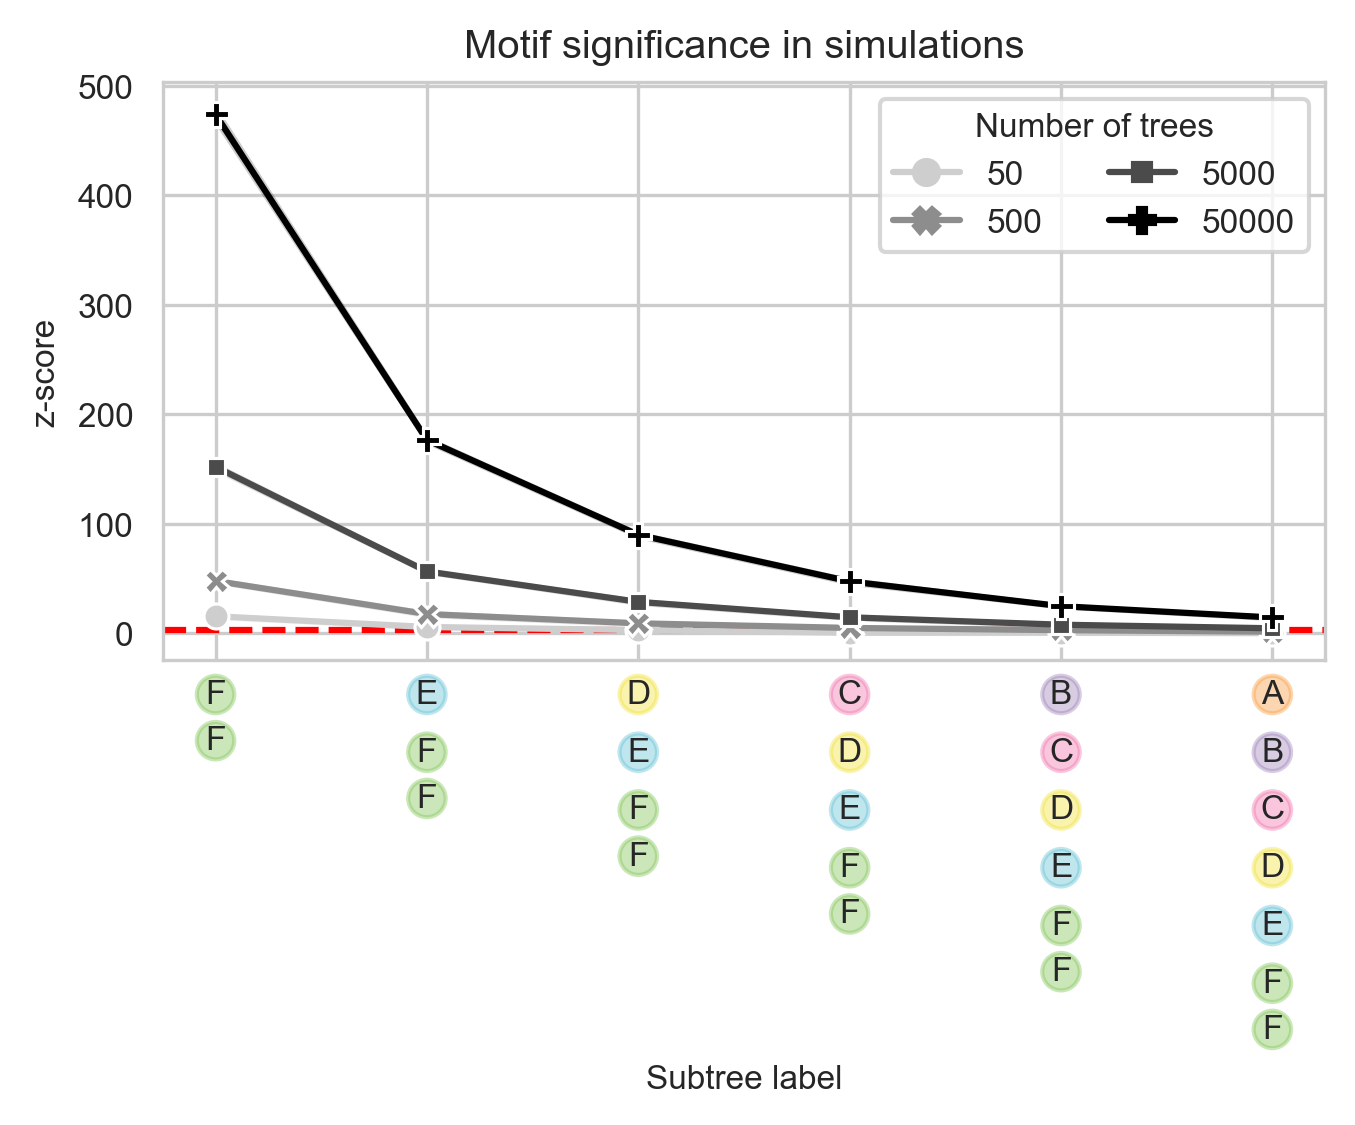

In [161]:
fig, ax = pyplot.subplots(figsize=(5, 2.5))

pyplot.axhline(y = 3, color = 'r', linestyle = '--')

sns.lineplot(data=df_meta_filt, 
             x='label', 
             y='z_score', 
             hue='num_trees', 
             style="num_trees",
             legend='full', 
             hue_norm=colors.LogNorm(vmin=df_meta['num_trees'].min(), vmax=df_meta['num_trees'].max()),
             markers=True,
             dashes=False,
             palette=cmap
            )       
#pyplot.yscale('log')
pyplot.legend(title='Number of trees', loc='upper right', ncol=2)
ax.set_xticklabels([])

for i, (subtree_label, subtree_type) in enumerate(zip(subtree_label_list, subtree_type_list)):
    make_annotation(i, subtree_label, subtree_type)

pyplot.ylabel("z-score")
pyplot.xlabel("Subtree label", labelpad=90)
pyplot.title("Motif significance in simulations")

pyplot.savefig(f"no_logsim_line_plot.svg", dpi=300, bbox_inches="tight")

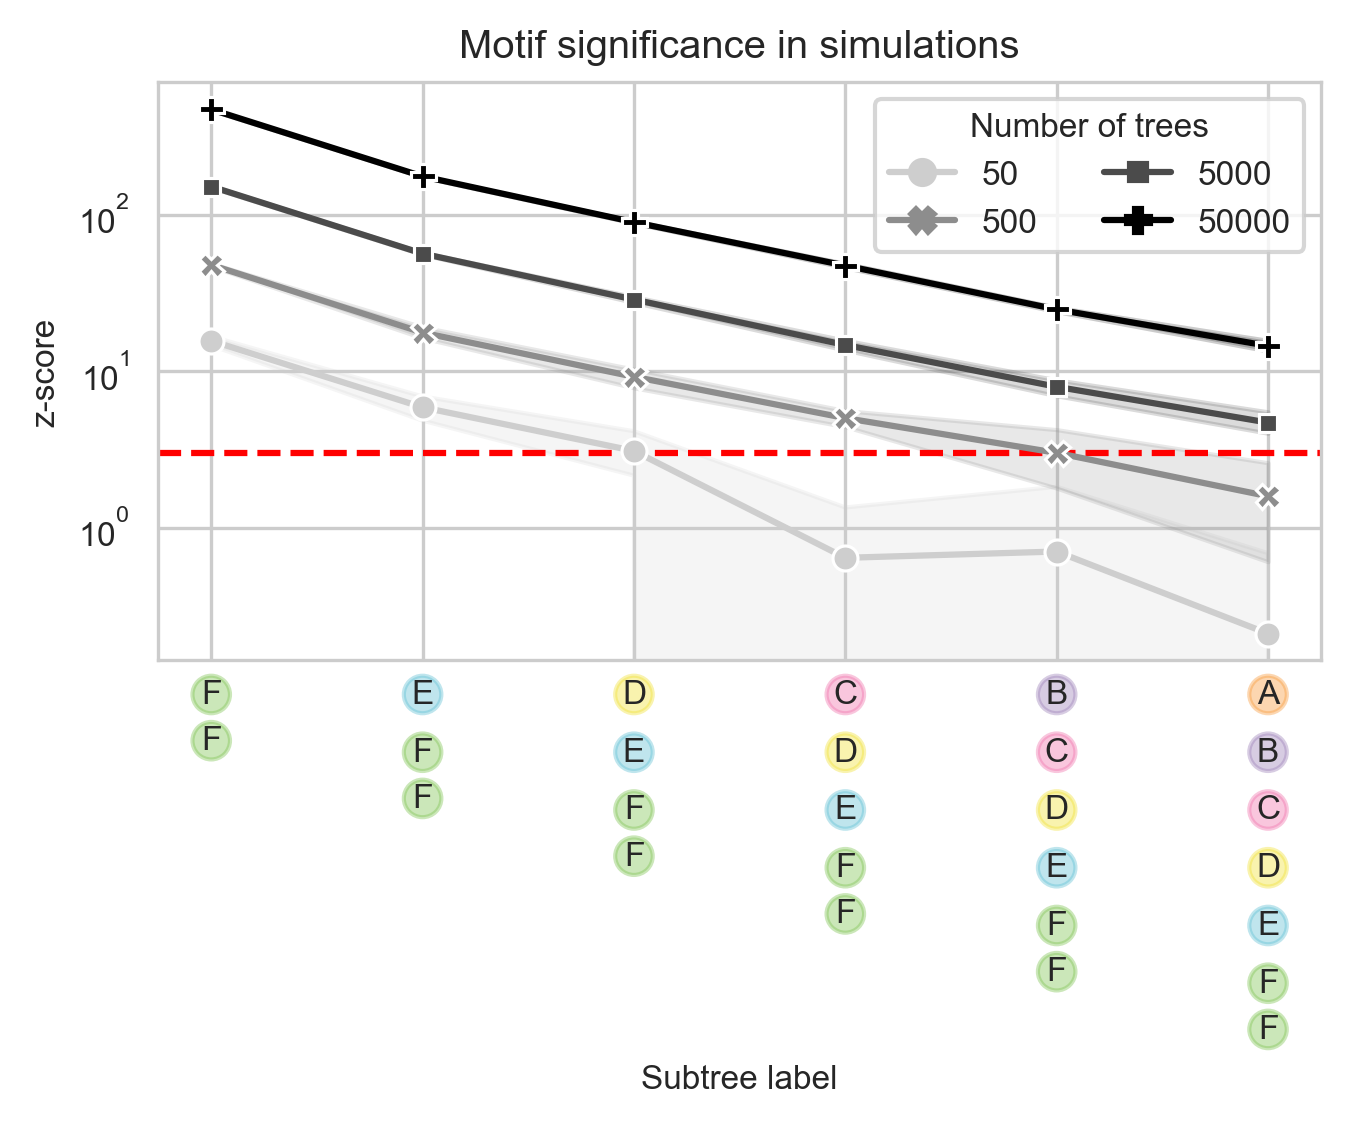

In [162]:
fig, ax = pyplot.subplots(figsize=(5, 2.5))

pyplot.axhline(y = 3, color = 'r', linestyle = '--')

sns.lineplot(data=df_meta_filt, 
             x='label', 
             y='z_score', 
             hue='num_trees', 
             style="num_trees",
             legend='full', 
             hue_norm=colors.LogNorm(vmin=df_meta['num_trees'].min(), vmax=df_meta['num_trees'].max()),
             markers=True,
             dashes=False,
             palette=cmap
            )       
pyplot.yscale('log')
pyplot.legend(title='Number of trees', loc='upper right', ncol=2)
ax.set_xticklabels([])

for i, (subtree_label, subtree_type) in enumerate(zip(subtree_label_list, subtree_type_list)):
    make_annotation(i, subtree_label, subtree_type)

pyplot.ylabel("z-score")
pyplot.xlabel("Subtree label", labelpad=90)
pyplot.title("Motif significance in simulations")

pyplot.savefig(f"sim_line_plot.svg", dpi=300, bbox_inches="tight")

In [77]:
num_trees = 50000
rep = 0 
all_trees_sorted = read_dataset(f"../data/comp_prog_model_v02/trees_trees{num_trees}_rep{rep}.txt")

tree_sizes = [len(re.findall('\w', i)) for i in all_trees_sorted]

In [78]:
np.median(tree_sizes)

5.0

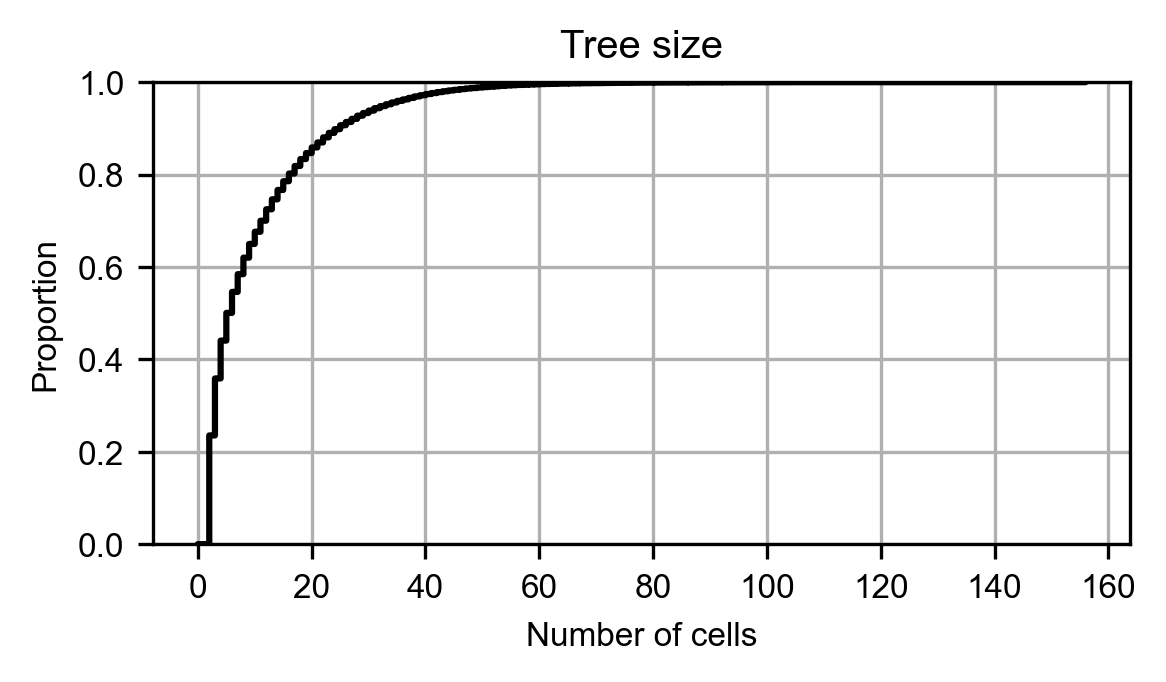

In [80]:
fig, ax = pyplot.subplots(figsize=(4.2, 2))

sns.ecdfplot(tree_sizes, color='black')
pyplot.xlabel("Number of cells")
pyplot.title('Tree size')
pyplot.grid(True)

pyplot.savefig(f"comp_prog_model_v02_tree_size.svg", bbox_inches="tight")

## old

In [ ]:
df_meta_hm = df_meta.groupby(['label', 'num_trees'])['z_score'].mean().to_frame().reset_index().pivot(index='num_trees', columns='label', values='z_score')
df_meta_hm

In [ ]:
fig, ax = pyplot.subplots(figsize=(6,3.5))

hm_vals = df_meta_hm.values
significant_cells = [(k, i) for i, j in enumerate(hm_vals) for k, l in enumerate(j) if (l > 3)]
sns.set(font='Arial', font_scale=0.75)

my_cmap = mpl.colors.LinearSegmentedColormap.from_list(colors=sns.color_palette("RdBu", n_colors=512)[256:], name='blues')
my_cmap.set_bad((1,1,1))
g = sns.heatmap(df_meta_hm, 
                annot=True, 
                fmt='.3g', 
                norm=LogNorm(), 
                cmap=my_cmap, 
                cbar_kws={'label': 'z-score'}, 
                linewidths=1, 
                linecolor='lightgray', 
                clip_on=False,
                xticklabels=False)

# add boxes around significant cells
for significant_cell in significant_cells:
    g.add_patch(Rectangle(significant_cell, 1, 1, fill=False, edgecolor='red', lw=2, clip_on=False))  
    
g.invert_yaxis()
g.invert_xaxis()
    
pyplot.ylabel("Number of trees")
pyplot.xlabel("Subtree label", labelpad=110)
pyplot.title("Motif significance in simulations")

pyplot.yticks(rotation=0)

for i, (subtree_label, subtree_type) in enumerate(zip(subtree_label_list[::-1], subtree_type_list[::-1])):
    make_annotation(i, subtree_label, subtree_type)

pyplot.savefig(f"comp_prog_model_hm.svg", dpi=300, bbox_inches="tight")

In [ ]:
subtree_label

In [ ]:
def _make_circle(color, size, x, y, alpha):
    da = DrawingArea(0, 0, 0, 0)
    p = mpatches.Circle((0, 0), size, color=color, alpha=alpha)
    da.add_artist(p)

    c1 = AnnotationBbox(da, 
                        (x,y),
                        xybox=(0, 0),
                        frameon=False,
                        xycoords=("data", "axes fraction"),
                        box_alignment=(0.5, 0.5),
                        boxcoords="offset points",
                        bboxprops={"edgecolor" : "none"},
                        pad=0)
    return c1

In [ ]:
def _make_circle(color, size, x, y, alpha):
    da = DrawingArea(0, 0, 0, 0)
    p = mpatches.Circle((0, 0), size, color=color, alpha=alpha)
    da.add_artist(p)

    c1 = AnnotationBbox(da, 
                        (x,y),
                        xybox=(0, 0),
                        frameon=False,
                        xycoords=("data", "axes fraction"),
                        box_alignment=(0.5, 0.5),
                        boxcoords="offset points",
                        bboxprops={"edgecolor" : "none"},
                        pad=0)
    return c1

subtree_type_list = ['doublet',
                     'triplet',
                     'quartet', 
                     'asym_quartet',
                     'asym_quintet',
                     'asym_sextet',
                     'asym_septet']

index_list = [[1,3], 
              [1,4,6], 
              [2,4,8,10], 
              [1,4,7,9], 
              [1,4,7,10,12], 
              [1,4,7,10,13,15], 
              [1,4,7,10,13,16,18]
              ]

y_list = [[-0.06, -0.15], 
          [-0.06, -0.18, -0.27],
          [-0.06, -0.15, -0.27, -0.36],
          [-0.06, -0.18, -0.30, -0.39],
          [-0.06, -0.18, -0.30, -0.42, -0.51],
          [-0.06, -0.18, -0.30, -0.42, -0.54, -0.63],
          [-0.06, -0.18, -0.30, -0.42, -0.54, -0.66, -0.75]
         ]

labelpad_list = [22.5, 40, 52.5, 60, 80, 100, 120]

df_annotations = pd.DataFrame({'subtree_type': subtree_type_list,
                               'index': index_list,
                               'y': y_list,
                               'labelpad': labelpad_list})
df_annotations

In [ ]:
def make_annotation(label, subtree_type):
    index_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['index'].values[0]
    y_list_subtree = df_annotations.loc[df_annotations['subtree_type']==subtree_type]['y'].values[0]

    for index, y in zip(index_list_subtree, y_list_subtree):
        c_str = label[index]
        x = label
        ax.add_artist(_make_circle(cell_color_dict[c_str], 4.5, x, y, 0.4))
        ax.annotate(c_str, 
                    xy=(x, y), 
                    verticalalignment="center", 
                    horizontalalignment="center",
                    annotation_clip=False, 
                    xycoords=("data", "axes fraction"),
                    **{'fontname':'DejaVu Sans', 'size':8})

In [ ]:
margins=0.05
bbox_to_anchor=(0, 0)  
figsize=(4, 2.5)

sns.set_style('whitegrid')
fig, ax = pyplot.subplots(figsize=figsize)
pyplot.setp(ax.collections)

pyplot.scatter(subtree_label_list, z_score_list, color='red')
pyplot.plot(subtree_label_list, z_score_list, color='red', alpha=0.5)

pyplot.grid(True)
ax.set_xticklabels([])

pyplot.title(f'Motif significance across various subtree sizes', y=1.02, **{'fontname':'DejaVu Sans', 'size':8})#, fontweight='bold')
pyplot.ylabel('z-score', **{'fontname':'DejaVu Sans', 'size':8})
pyplot.yticks(**{'fontname':'DejaVu Sans', 'size':8})

subtree_type_list = ['doublet',
                     'triplet',
                     'asym_quartet',
                     'asym_quintet',
                     'asym_sextet'
                     ]

for subtree_label, subtree_type in zip(subtree_label_list, subtree_type_list):
    make_annotation(subtree_label, subtree_type)

pyplot.xlabel('Subtree label', labelpad=100, **{'fontname':'DejaVu Sans', 'size':8})